In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

from keras.layers import Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn 

from tqdm import tqdm

2023-05-17 08:29:37.980789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 08:29:38.692316: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-17 08:29:38.692395: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-17 08:29:41.231949: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
data_imgs = np.load('../Kanji-recognizer/data/kkanj-imgs.npz')
data_labels = np.load('../Kanji-recognizer/data/kkanji-labels.npz')

imgs = data_imgs['arr_0']
labels = data_labels['arr_0']

def kanji(kaniUnicode):
    return chr(int(kaniUnicode[2:], 16))

X = imgs[14000:44000]
Z = labels[14000:44000]


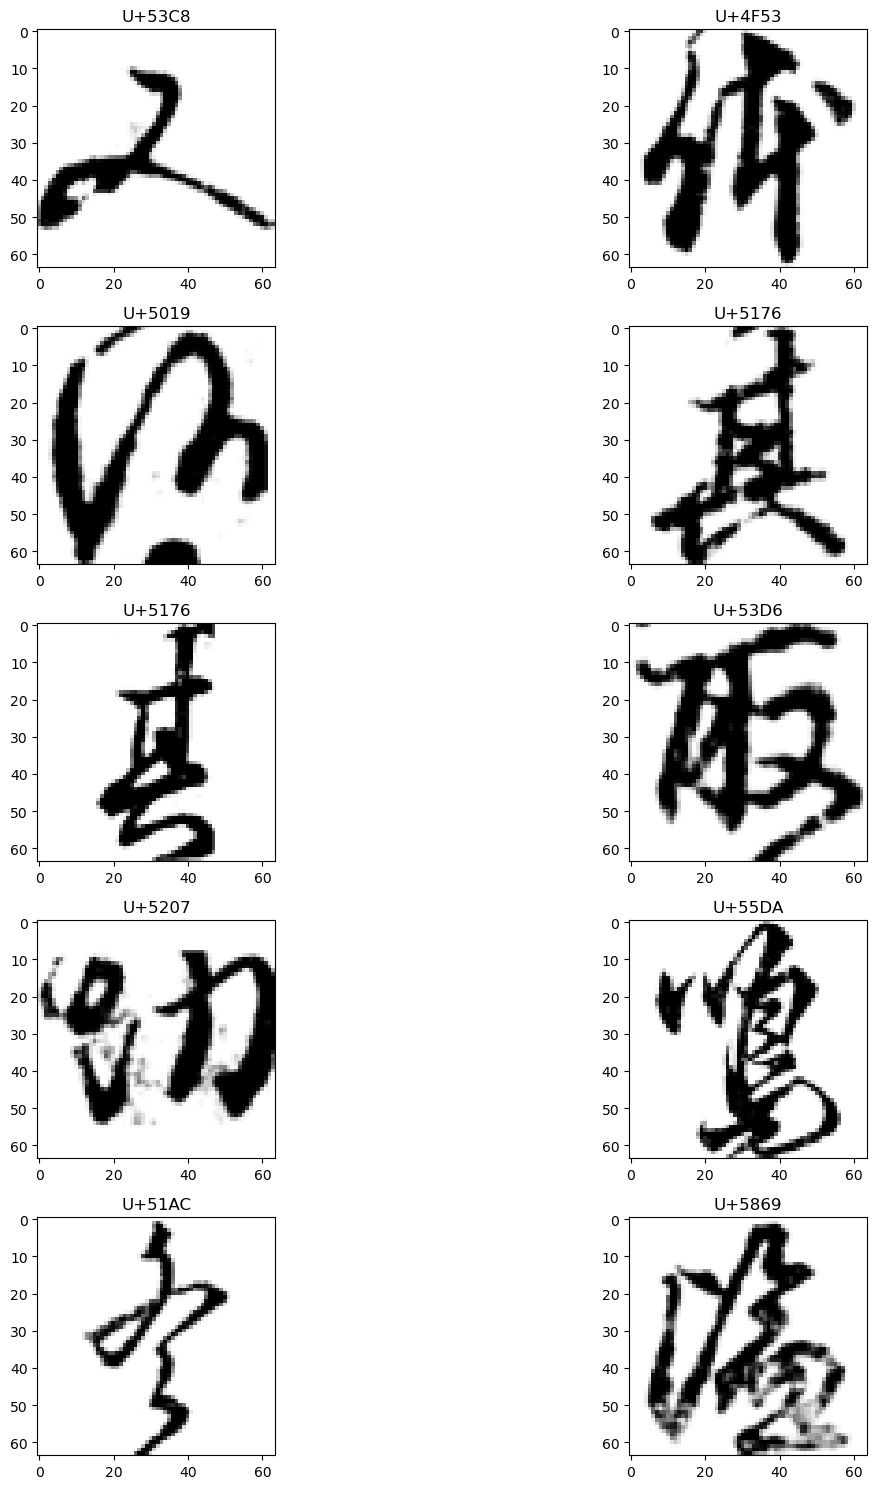

In [3]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l], cmap='Greys')
        ax[i,j].set_title(Z[l])
        
        
plt.tight_layout()

In [4]:
len(np.unique(Z))

524

In [5]:
le=LabelEncoder()


Y=le.fit_transform(Z)


Y=to_categorical(Y,len(np.unique(Z)))


X=np.array(X)


X=X/255


In [6]:
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=0.25, random_state=42)
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [7]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size= (3,3), padding= 'Same', activation='relu', input_shape = (64,64, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size= (3,3), padding= 'Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 96, kernel_size= (1,1), padding= 'Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 96, kernel_size= (1,1), padding= 'Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(len(np.unique(Z)), activation="softmax"))

2023-05-17 08:29:55.029879: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-17 08:29:55.032473: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-17 08:29:55.032592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (108bb72cdfce): /proc/driver/nvidia/version does not exist
2023-05-17 08:29:55.034865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
batch_size=200
epochs=3

from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1,factor=0.1)

In [9]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0,
    width_shift_range=0,
    height_shift_range=0,
    horizontal_flip=False,
    vertical_flip=False
)

#datagen.fit(x_train.reshape(10500, 64, 64, 1))

In [10]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 96)        6240      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 96)         0

In [12]:
History = model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test), verbose=1, steps_per_epoch=x_train.shape[0] // batch_size)

2023-05-17 08:29:56.317620: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 368640000 exceeds 10% of free system memory.


Epoch 1/3
112/112 [==============================] - 54s 472ms/step - loss: 3.6113 - accuracy: 0.3433 - val_loss: 2.0616 - val_accuracy: 0.5916
Epoch 2/3
112/112 [==============================] - 52s 463ms/step - loss: 1.3846 - accuracy: 0.7134 - val_loss: 1.1305 - val_accuracy: 0.7725
Epoch 3/3
112/112 [==============================] - 50s 449ms/step - loss: 0.7329 - accuracy: 0.8239 - val_loss: 0.8976 - val_accuracy: 0.8105


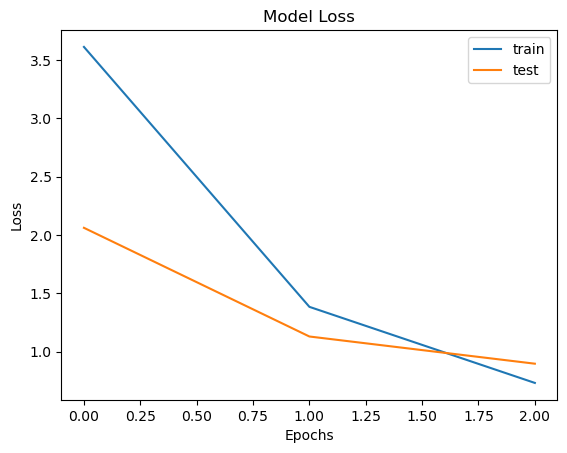

In [13]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [14]:
accuracy_history = []
accuracy_history_img = []

1/1 [==============================] - 0s 117ms/step
Predicted class: 5
Predicted class probability: 99.96849298477173 %


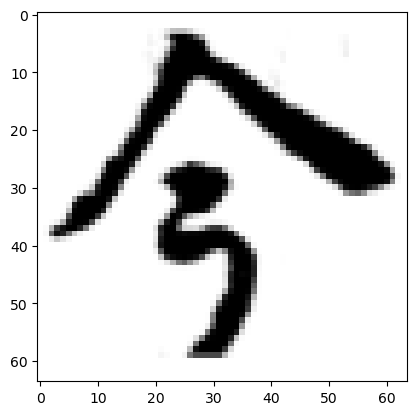

In [15]:
from matplotlib import pyplot


results = model.evaluate(x_test, y_test)
image_number = 2172
new_image = tf.expand_dims(x_test[image_number], 0)
predictions = model.predict(new_image)
predicted_class_index = predictions.argmax(axis=-1)[0]
predicted_class_probability = predictions[0][predicted_class_index]
print('Predicted class:', predicted_class_index)
print('Predicted class probability:', predicted_class_probability*100, "%")

accuracy_history.append(predicted_class_probability*100)
accuracy_history_img.append(image_number)

pyplot.imshow(x_test[image_number], cmap='Greys')
#print(kanji(y_test[image_number]))


In [16]:
import webscraping

class_prediction = 77
print("Code: ", np.unique(Z)[class_prediction])
print(kanji(np.unique(Z)[class_prediction]))
webscraping.get_meaning(kanji(np.unique(Z)[class_prediction]))

Code:  U+4FF3
俳

haiku, 
actor



In [24]:
from matplotlib import pyplot
import random

accuracy_history = []
accuracy_history_img = []
predicted_class_index_list = [] 

for _ in range(100):
    image_number = random.randint(0, len(x_test) - 1)
    new_image = tf.expand_dims(x_test[image_number], 0)
    predictions = model.predict(new_image)
    predicted_class_index = predictions.argmax(axis=-1)[0]
    predicted_class_probability = predictions[0][predicted_class_index]
    print('Predicted class:', predicted_class_index)
    print('Predicted class probability:', predicted_class_probability * 100, "%")

    accuracy_history.append(predicted_class_probability * 100)
    accuracy_history_img.append(image_number)
    predicted_class_index_list.append(predicted_class_index)

    # pyplot.imshow(x_test[image_number], cmap='Greys')
    # pyplot.show()


1/1 [==============================] - 0s 46ms/step
Predicted class: 87
Predicted class probability: 99.99685287475586 %
1/1 [==============================] - 0s 47ms/step
Predicted class: 0
Predicted class probability: 99.9768316745758 %
1/1 [==============================] - 0s 37ms/step
Predicted class: 87
Predicted class probability: 97.30954170227051 %
1/1 [==============================] - 0s 39ms/step
Predicted class: 160
Predicted class probability: 99.09752011299133 %
1/1 [==============================] - 0s 47ms/step
Predicted class: 87
Predicted class probability: 77.84797549247742 %
1/1 [==============================] - 0s 38ms/step
Predicted class: 160
Predicted class probability: 45.678240060806274 %
1/1 [==============================] - 0s 41ms/step
Predicted class: 151
Predicted class probability: 99.8543381690979 %
1/1 [==============================] - 0s 38ms/step
Predicted class: 396
Predicted class probability: 30.660104751586914 %
1/1 [========================

[99.99685287475586, 99.9768316745758, 97.30954170227051, 99.09752011299133, 77.84797549247742, 45.678240060806274, 99.8543381690979, 30.660104751586914, 80.13769388198853, 59.898972511291504, 39.619651436805725, 95.19952535629272, 97.80457019805908, 91.66878461837769, 41.39466881752014, 96.22648358345032, 99.51496720314026, 94.93895769119263, 36.16112470626831, 99.71062541007996, 99.9908447265625, 29.983633756637573, 99.10091161727905, 76.7666757106781, 15.027780830860138, 92.79251098632812, 98.2858419418335, 99.7236967086792, 98.8827109336853, 99.92840886116028, 99.34844374656677, 83.12490582466125, 99.80308413505554, 13.380159437656403, 56.57932758331299, 99.63611960411072, 99.33027029037476, 57.37914443016052, 87.6872718334198, 96.8094527721405, 99.89444613456726, 98.69959354400635, 85.24582982063293, 99.43786263465881, 99.9879240989685, 11.476065218448639, 37.834954261779785, 98.32126498222351, 81.92277550697327, 99.24836754798889, 73.95554184913635, 22.157397866249084, 97.94843792

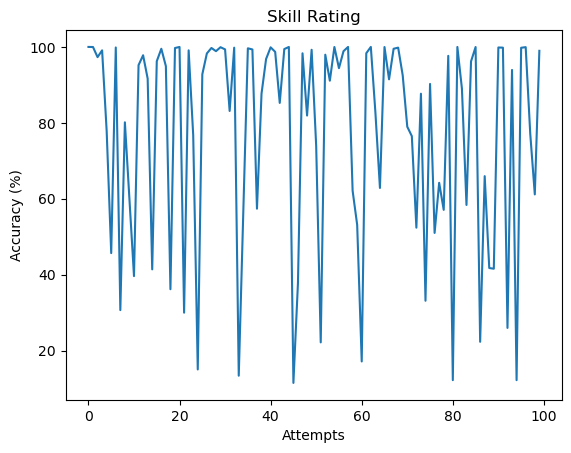

In [28]:

print(accuracy_history)
plt.plot(accuracy_history)
plt.title('Skill Rating')
plt.ylabel('Accuracy (%)')
plt.xlabel('Attempts')
plt.show()

In [26]:
result = []
for a, b, c in zip(accuracy_history_img, accuracy_history, predicted_class_index_list):
    result.append((a, b, c))

for r in range(len(result)):
    image_number = result[r][0]
    accuracy = result[r][1]
    predicted_class_index = result[r][2]
    
    print("Element:", r+1)
    print("Image number:", image_number)
    print("Accuracy:", accuracy, "%")
    print("Predicted class index:", predicted_class_index)
    print()

average = sum(accuracy_history) / len(accuracy_history)
print("Average:", average, "%")

Element: 1
Image number: 2231
Accuracy: 99.99685287475586 %
Predicted class index: 87

Element: 2
Image number: 2308
Accuracy: 99.9768316745758 %
Predicted class index: 0

Element: 3
Image number: 4954
Accuracy: 97.30954170227051 %
Predicted class index: 87

Element: 4
Image number: 1725
Accuracy: 99.09752011299133 %
Predicted class index: 160

Element: 5
Image number: 5878
Accuracy: 77.84797549247742 %
Predicted class index: 87

Element: 6
Image number: 2808
Accuracy: 45.678240060806274 %
Predicted class index: 160

Element: 7
Image number: 1667
Accuracy: 99.8543381690979 %
Predicted class index: 151

Element: 8
Image number: 5631
Accuracy: 30.660104751586914 %
Predicted class index: 396

Element: 9
Image number: 5195
Accuracy: 80.13769388198853 %
Predicted class index: 158

Element: 10
Image number: 6987
Accuracy: 59.898972511291504 %
Predicted class index: 190

Element: 11
Image number: 2162
Accuracy: 39.619651436805725 %
Predicted class index: 73

Element: 12
Image number: 4140
Acc